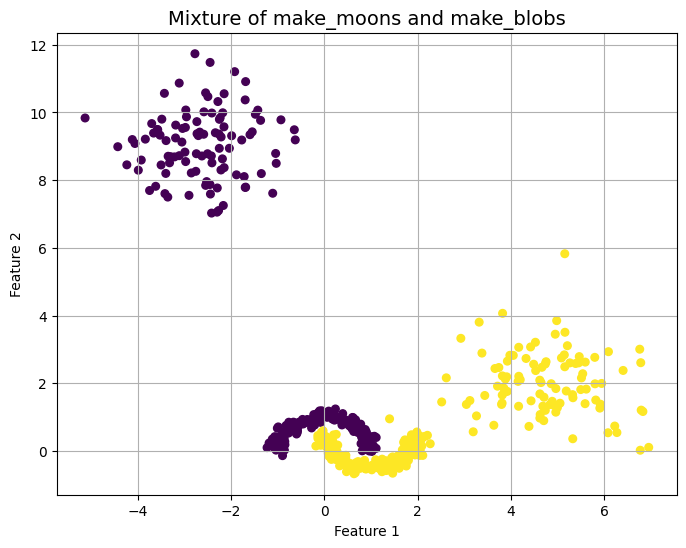

In [1]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_blobs

# Generate make_moons dataset
X_moons, y_moons = make_moons(n_samples=300, noise=0.1, random_state=42)

# Generate make_blobs dataset
X_blobs, y_blobs = make_blobs(n_samples=200, centers=2, random_state=42)

# Combine both datasets
X = np.vstack([X_moons, X_blobs])
y = np.hstack([y_moons, y_blobs])

# Plot the combined dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=30)
plt.title("Mixture of make_moons and make_blobs", fontsize=14)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()

Silhouette Score for DBSCAN: 0.322


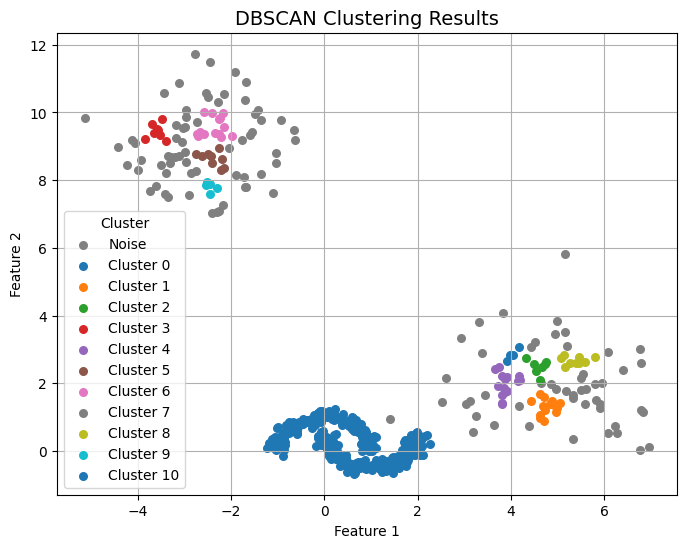

In [2]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# DBSCAN Parameters
eps = 0.3  # Maximum distance between two samples for them to be considered as in the same neighborhood
min_samples = 5  # Minimum number of points to form a dense region

# Apply DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(X)

# Calculate Silhouette Score
if len(set(dbscan_labels)) > 1:
    silhouette = silhouette_score(X, dbscan_labels)
else:
    silhouette = -1  # Not enough clusters for silhouette score

print(f"Silhouette Score for DBSCAN: {silhouette:.3f}")

# Plot DBSCAN Results
plt.figure(figsize=(8, 6))
unique_labels = np.unique(dbscan_labels)
for label in unique_labels:
    if label == -1:
        plt.scatter(X[dbscan_labels == label, 0], X[dbscan_labels == label, 1], c='gray', label='Noise', s=30)
    else:
        plt.scatter(X[dbscan_labels == label, 0], X[dbscan_labels == label, 1], label=f'Cluster {label}', s=30)

plt.title("DBSCAN Clustering Results", fontsize=14)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(title="Cluster", loc="best")
plt.grid(True)
plt.show()

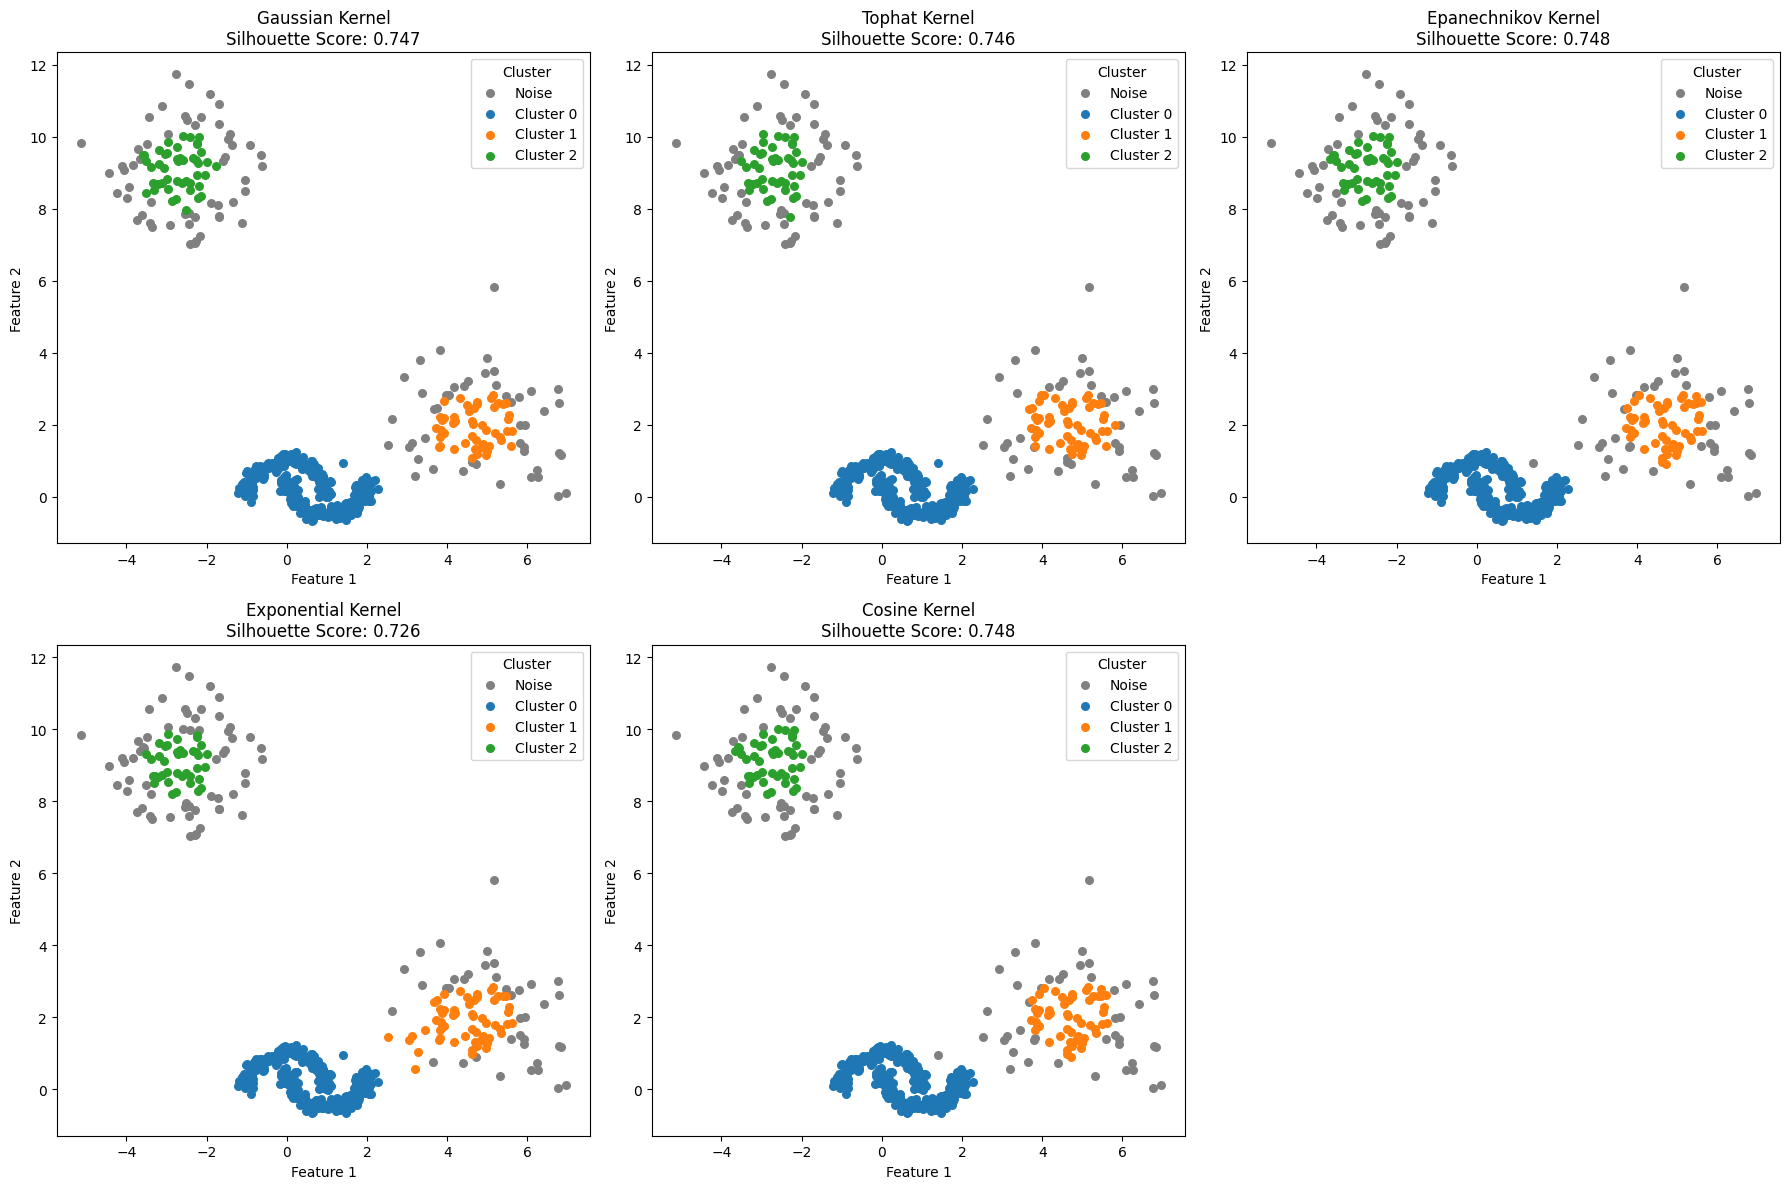

Gaussian Kernel - Silhouette Score: 0.747
Tophat Kernel - Silhouette Score: 0.746
Epanechnikov Kernel - Silhouette Score: 0.748
Exponential Kernel - Silhouette Score: 0.726
Cosine Kernel - Silhouette Score: 0.748


In [6]:
from sklearn.neighbors import KernelDensity

# Parameters for Kernel Density Estimation
h = 0.8  # Bandwidth for density estimation
density_threshold_percentile = 80  # Top 80% as high-density points
kernels = ['gaussian', 'tophat', 'epanechnikov', 'exponential', 'cosine']

# Kernel Density-Based Clustering Function
def perform_kernel_clustering(X, kernel):
    kde = KernelDensity(kernel=kernel, bandwidth=h)
    kde.fit(X)

    log_densities = kde.score_samples(X)
    densities = np.exp(log_densities)

    density_threshold = np.percentile(densities, 100 - density_threshold_percentile)
    high_density_points = np.where(densities >= density_threshold)[0]

    labels = np.full(X.shape[0], -1, dtype=int)
    cluster_id = 0

    for point_idx in high_density_points:
        if labels[point_idx] != -1:
            continue
        labels[point_idx] = cluster_id
        queue = [point_idx]

        while queue:
            current_point = queue.pop(0)
            for other_idx in high_density_points:
                if labels[other_idx] != -1:
                    continue
                distance = np.linalg.norm(X[current_point] - X[other_idx])
                if distance < h:
                    labels[other_idx] = cluster_id
                    queue.append(other_idx)
        cluster_id += 1

    if len(set(labels[high_density_points])) > 1:
        silhouette = silhouette_score(X[high_density_points], labels[high_density_points])
    else:
        silhouette = -1

    return labels, silhouette

# Plot results for each kernel
plt.figure(figsize=(18, 12))
results = {}
for i, kernel in enumerate(kernels):
    labels, silhouette = perform_kernel_clustering(X, kernel)
    results[kernel] = silhouette

    plt.subplot(2, 3, i + 1)
    unique_labels = np.unique(labels)
    for label in unique_labels:
        if label == -1:
            plt.scatter(X[labels == label, 0], X[labels == label, 1], c='gray', s=30, label='Noise')
        else:
            plt.scatter(X[labels == label, 0], X[labels == label, 1], s=30, label=f'Cluster {label}')
    plt.title(f"{kernel.capitalize()} Kernel\nSilhouette Score: {silhouette:.3f}")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend(title="Cluster", loc="best")

plt.tight_layout()
plt.show()

# Print Silhouette Scores for each kernel
for kernel, score in results.items():
    print(f"{kernel.capitalize()} Kernel - Silhouette Score: {score:.3f}")